<a href="https://colab.research.google.com/github/100jy/voice_competition/blob/master/MFCC_80_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
import keras
from tqdm import tqdm
from glob import glob
from scipy.io import wavfile
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Flatten, BatchNormalization,Dropout, Activation, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import librosa
import librosa.display

In [39]:
y_train = pd.read_csv('drive/My Drive/data/train_answer.csv',index_col=0)
y_train = y_train.values

x_train.shape, y_train.shape

((100000, 80, 44, 2), (100000, 30))

# 데이터 확인 및 채널 추가


In [21]:
#MFCC
x_train = pd.read_pickle('drive/My Drive/data/x_trian_mfcc_80.pickle')
source = x_train.values


##normalize
def normalize(x):
  return (x - np.mean(x)) / np.std(x)

## binary
def make_binary(x):
  np.ones_like(len(x))
  mask = (x > 0)
  return np.ones_like(len(x)) * mask
 
binary = list((map(make_binary,source)))
binary =  np.array(binary)

x_nor = list((map(normalize,source)))
x_nor = np.array(x_nor)

## 결과 확인

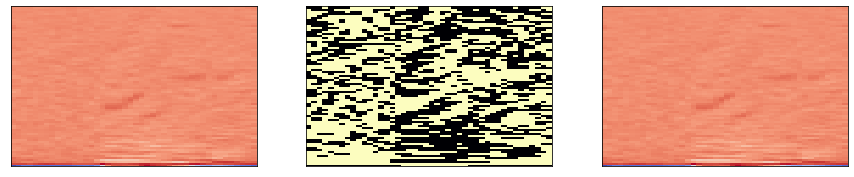

In [9]:
mfcc = [source[0].reshape(80,-1),binary[0].reshape(80,-1),x_nor[0].reshape(80,-1)]
plt.figure(figsize=(15,10))

for i in range(3):
  st = '33'+str(i+1)
  plt.subplot(st)
  librosa.display.specshow(mfcc[i])

In [22]:
x_nor = x_nor.reshape(100000,80,-1,1)
binary = binary.reshape(100000,80,-1,1)

In [23]:
x_nor.shape

(100000, 80, 44, 1)

In [34]:
# 데이터 2ch로 수정...
x_train = np.concatenate((x_nor.T, binary.T), axis=0)
x_train.shape

(2, 44, 80, 100000)

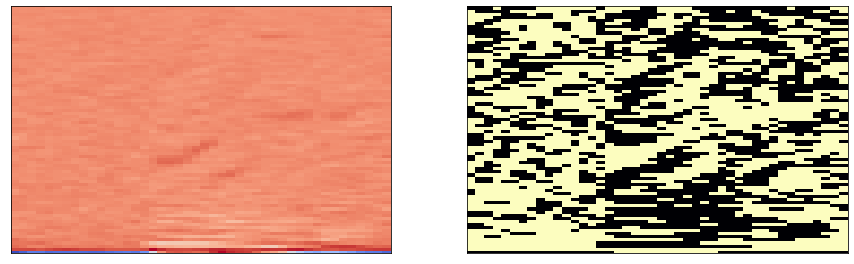

In [27]:
plt.figure(figsize=(15,10))
for i in range(2):
  st = '22'+str(i+1)
  plt.subplot(st)
  librosa.display.specshow(x_train[i].T[0])

In [35]:
x_train = x_train.T

In [36]:
x_train.shape

(100000, 80, 44, 2)

# model architecture

In [48]:
### padding valid, dropout 0.3, shorter fully-conneted
##GlobalAveragePooling
#CNN
model = Sequential()
model.add(Conv2D(64, kernel_size = (3,3), strides = (1,1),activation='relu', input_shape = (x_train.shape[1], x_train.shape[2],2)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, kernel_size = (3,3), strides = (1,1),activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, kernel_size = (3,3), strides = (1,1),activation='relu'))
model.add(MaxPooling2D((2,2)))
'''
model.add(Conv2D(128, kernel_size = (3,3), strides = (1,1),activation='relu'))
model.add(MaxPooling2D((2,2)))
'''
model.add(GlobalAveragePooling2D())

#fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(30, activation='softmax'))
model.compile(loss=keras.losses.KLDivergence(), optimizer = 'adam')
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 78, 42, 64)        1216      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 39, 21, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 37, 19, 128)       73856     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 18, 9, 128)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 16, 7, 128)        147584    
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 8, 3, 128)         0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 128)              

In [ ]:
### padding valid, dropout 0.3, shorter fully-conneted
##GlobalAveragePooling
#CNN
model = Sequential()
model.add(Conv2D(64, kernel_size = (3,3), strides = (1,1),activation='relu', input_shape = (x_train.shape[1], x_train.shape[2],2)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, kernel_size = (3,3), strides = (1,1),activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, kernel_size = (3,3), strides = (1,1),activation='relu'))
model.add(MaxPooling2D((2,2)))
'''
model.add(Conv2D(128, kernel_size = (3,3), strides = (1,1),activation='relu'))
model.add(MaxPooling2D((2,2)))
'''
model.add(GlobalAveragePooling2D())

#fully connected layer
#1-layer add
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(30, activation='softmax'))
model.compile(loss=keras.losses.KLDivergence(), optimizer = 'adam')
model.summary()

In [ ]:
model_path = 'drive/My Drive/data/model_2D_80/'
if not os.path.exists(model_path):
  os.mkdir(model_path)

# validattion 기준 모델 갱신
model_file = model_path + 'epoch_{epoch:03d}_val_{val_loss:3f}.hdf5'
checkpoint = ModelCheckpoint(filepath = model_file, monitor = 'val_loss', verbose = 1, save_best_only =True)

#10회간 validatation 좋아지지 않으면 early stop
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

history = model.fit(x_train, y_train, epochs = 100, batch_size = 64, validation_split = 0.2, shuffle = True,
                    callbacks = [checkpoint, early_stop])

Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 16s 200us/step - loss: 1.9565 - val_loss: 1.8318

Epoch 00001: val_loss improved from inf to 1.83175, saving model to drive/My Drive/data/model_2D_80/epoch_001_val_1.831752.hdf5
Epoch 2/100
80000/80000 [==============================] - 16s 197us/step - loss: 1.7846 - val_loss: 1.7044

Epoch 00002: val_loss improved from 1.83175 to 1.70444, saving model to drive/My Drive/data/model_2D_80/epoch_002_val_1.704442.hdf5
Epoch 3/100
80000/80000 [==============================] - 16s 196us/step - loss: 1.6991 - val_loss: 1.6268

Epoch 00003: val_loss improved from 1.70444 to 1.62679, saving model to drive/My Drive/data/model_2D_80/epoch_003_val_1.626789.hdf5
Epoch 4/100
80000/80000 [==============================] - 16s 197us/step - loss: 1.6359 - val_loss: 1.5701

Epoch 00004: val_loss improved from 1.62679 to 1.57011, saving model to drive/My Drive/data/model_2D_80/epoch_004_val_1.57

In [ ]:
# 훈련 결과를 확인합니다.
# validation 성능 fool하다....
plt.plot(history.epoch, history.history['loss'], '-o', label='training_loss')
plt.plot(history.epoch, history.history['val_loss'], '-o', label='validation_loss')
plt.legend()
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
#x_test 문제있는거 같음...
# 검증 wav 파일로부터 Feature를 만듭니다.
x_test = pd.read_pickle('drive/My Drive/data/x_test_MFCC.pickle')
x_test = x_test.values
x_test = list((map(lambda x : x / max(x),x_test)))
x_test =  np.array(x_test)
x_test = x_test.reshape(x_test.shape[0], 40,-1, 1)

# 가장 좋은 모델의 weight를 불러옵니다.
weigth_file = glob('drive/My Drive/data/model_2D/*.hdf5')[-1]
print(weigth_file)
model.load_weights(weigth_file)

# 예측 수행
y_pred = model.predict(x_test)

# 예측 결과로 제출 파일을 생성합니다.
submission = pd.read_csv('drive/My Drive/data/submission.csv', index_col=0)
submission.loc[:, :] = y_pred
submission.to_csv('drive/My Drive/data/submission.csv')